# Process parcel-level Cloud Factory annotations for Batch #1

In [88]:
import json
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

from shapely import geometry
from tqdm import tqdm

In [3]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
INPUT_FP = os.path.join(OAK_FP, 'CloudFactory', 'results', 'B1_Preliminary_WithBuildings')

In [6]:
# Load current images (38% complete) that include small building annotations
sbuild_parcels = glob(os.path.join(INPUT_FP, '*.json'))
print('Number of parcels: {}'.format(len(sbuild_parcels)))

Number of parcels: 469


In [91]:
def count_annotations(res):
    """
    Note: this function only correctly captures whether an annotation is in the left (2016) or right
    (2020) half of the image. It does not distinguish between bottom and top rows. (Which seems fine)
    given that some annotations were incorrectly made on the top row. 
    """
    img_width, img_height = res['metadata']['system']['width'], res['metadata']['system']['height']
    box_2016 = geometry.Polygon([[0, 0], [img_width //2, 0], [img_width//2, img_height], [0, img_height], [0, 0]])
    box_2020 = geometry.Polygon([[img_width//2, 0], [img_width, 0], [img_width, img_height], 
                             [img_width//2, img_height], [img_width//2, 0]])
    
    count_dict = {'2016': [0], '2020': [0]}
    for annotation in res['annotations']:
        if 'coordinates' in annotation.keys():
            # define annotation year 
            # * get polygon centroid and figure out if in left or right half
            ann_pointlist = annotation['coordinates'][0]
            ann_poly = geometry.Polygon([[p['x'], p['y']] for p in ann_pointlist])
            
            if box_2020.contains(ann_poly):
                count_dict['2020'][0] += 1
            else:
                count_dict['2016'][0] += 1

    return count_dict

In [92]:
# Collect annotations for each parcel
annotations_df = pd.DataFrame()
for parcel_file in tqdm(sbuild_parcels):
    res_parcel = json.load(open(parcel_file))
    count_dict = count_annotations(res_parcel)
    count_dict['APN'] = [parcel_file.split(os.path.sep)[-1].replace('.json', '')]
    annotations_df = pd.concat([annotations_df, pd.DataFrame.from_dict(count_dict)])

100%|██████████| 469/469 [00:04<00:00, 97.79it/s] 


In [94]:
# Identify parcels with CF annotated small building construction
growth_df = annotations_df.loc[annotations_df['2020'] > annotations_df['2016']]

In [95]:
growth_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 0 to 0
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   2016    23 non-null     int64 
 1   2020    23 non-null     int64 
 2   APN     23 non-null     object
dtypes: int64(2), object(1)
memory usage: 736.0+ bytes


In [96]:
growth_df

,2016,2020,APN
0,0,1,30334023
0,0,1,30327016
0,1,2,24960051
0,0,1,01511081
0,0,1,46432056
0,0,1,30341002
0,0,1,24529043
0,0,1,29928063
0,0,1,42935022
0,0,1,44732030


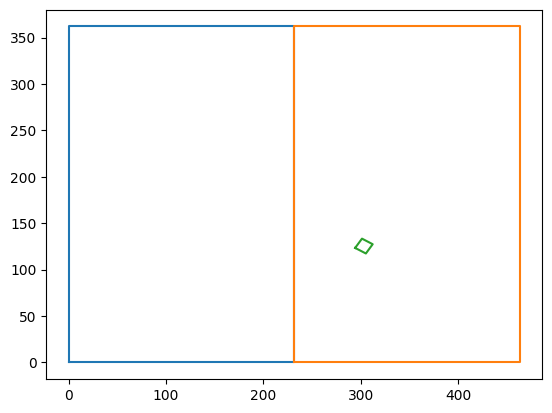

In [84]:
xs, ys = zip(*box_2016.exterior.coords) #create lists of x and y values
xs1, ys1 = zip(*box_2020.exterior.coords) #create lists of x and y values
xs2, ys2 = zip(*ann_poly.exterior.coords) #create lists of x and y values
#xs3, ys3 = zip(*ann_poly2.exterior.coords) #create lists of x and y values

plt.figure()
plt.plot(xs,ys) 
plt.plot(xs1,ys1) 
plt.plot(xs2,ys2) 
#plt.plot(xs3,ys3) 
plt.show()